In [1]:
import ee
from tqdm import tqdm
import geopandas as gpd
from sqlalchemy import create_engine
from torch.utils.data import DataLoader
from torchgeo.datasets import BoundingBox, stack_samples
from shapely.geometry import box

from forestvision.samplers.utils import roi_to_tiles
from forestvision.samplers import TileGeoSampler
from forestvision.datasets import GPDFeatureCollection, GEE3Dep, GEEDynamicWorld
from lm_dpl.utils import get_config

2025-12-26 17:10:36 - lm_dpl.utils.logging_utils - INFO - Project logging initialized to file: /home/ygalvan/lm-dpl/logs/lm_dpl_20251226.log


## Configuration and Initialization

In [2]:
config = get_config() 
engine = create_engine(config.postgres_url)
ee.Initialize(project=config.GEE_PROJECT)

## Define ROI and splirt into tiles for downloading data

In [3]:
# Get bounding box for Oregon and Washington
q = """
    SELECT ST_Envelope(ST_Extent(ST_Transform(geom, 5070))) AS geometry 
    FROM ( 
        select geom from public.s_oregon_cty
        union
        select geom from public.s_washington_cty
    );
"""

orwa = gpd.read_postgis(
    q,
    engine,
    geom_col="geometry",
)

roi = GPDFeatureCollection(orwa)

In [4]:
tiles = roi_to_tiles(roi.bounds, size=(2048, 2048), res=10)
len(tiles)

1591

In [5]:
tiles_df = gpd.GeoDataFrame(geometry=[box(*t) for t in tiles], crs="EPSG:5070")

## Fetch Oregon and Washington elevation data

In [12]:
def to_bbox(tile):
    minx, miny, maxx, maxy = tile
    return BoundingBox(minx, maxx, miny, maxy, 0, 0)

In [13]:
path = f"../data/{GEE3Dep.__name__.lower()}"

In [14]:
dem = GEE3Dep(roi=roi.bounds, res=10)

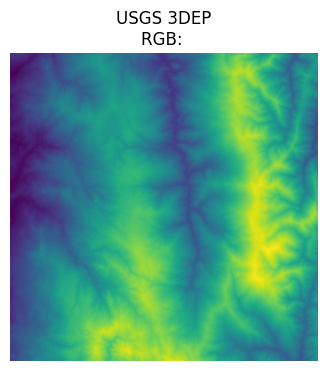

In [15]:
item = dem.__getitem__(to_bbox(tiles[0]))
item["image"].shape
dem.plot(item);

In [16]:
# Calculate size per tile
h, w = item["image"].squeeze().shape
(h*w*32)/8/1024/1024  # MB per tile

16.0

In [ ]:
sampler = TileGeoSampler(dataset=dem, tiles=tiles_df)
dataloader = DataLoader(dataset=dem, sampler=sampler, batch_size=5, num_workers=4, collate_fn=stack_samples)

In [ ]:
# Uncomment to download data
# for batch in tqdm(dataloader):
#     batch

## Fetch Oregon and Washington Dynamic World data

In [17]:
dw_path = f"../data/{GEEDynamicWorld.__name__.lower()}"

In [ ]:
dw = GEEDynamicWorld(date_start="2025-09-01", date_end="2025-09-30", class_name="trees", 
                     roi=roi.bounds, res=10, path=dw_path, download=True)

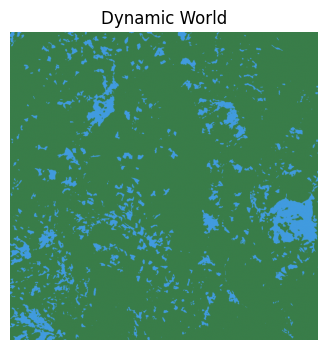

In [24]:
item = dw.__getitem__(to_bbox(tiles[0]))
dw.plot(item);

In [ ]:
sampler = TileGeoSampler(dataset=dw, tiles=tiles_df)
dataloader = DataLoader(dataset=dw, sampler=sampler, batch_size=5, num_workers=4, collate_fn=stack_samples)

In [ ]:
# Uncomment to download data
# for batch in tqdm(dataloader):
#     batch